## N and f effect in tracer transport along several cross-sections 

Transports across several cross sections in the domain (See plot further down)

Advective tracer transport $\Phi_{Tadv}=C\vec{u}\cdot\vec{a}$ from model output diagnostics.

Diffusive tracer transport $\Phi_{Tdiff}$ from model output (Includes diffusion due to advection scheme)

| variable  | dims | units | description |
|:---------:|:---------:|:---------:|:---------:|
| UTRAC01   |   (T, Zmd000090, Y, Xp1) | Mol/L.m/s | Zonal Mass-Weighted Transp of Tr1 |
| VTRAC01   |   (T, Zmd000090, Yp1, X) | Mol/L.m/s | Meridional Mass-Weighted Transp of Tr1 |
| WTRAC01   |   (T, Zmd000090, Y, X)   | Mol/L.m/s | Vertical Mass-Weighted Transp of Tr1 |  
| ADVrTr01  |   (T, Zld000090, Y, X)   | Mol/L.m^3/s| Zonal Advective Flux of Tr1 |
| ADVxTr01  |   (T, Zmd000090, Y, Xp1) | Mol/L.m^3/s| Meridional Advective Flux of Tr1 |
| ADVyTr01  |   (T, Zmd000090, Yp1, X) | Mol/L.m^3/s| Vertical Advective Flux of Tr1 |
| DFrETr01  |   (T, Zld000090, Y, X)   | Mol/L.m^3/s| Vertical Diffusive Flux of Tr1 (Explicit part) |
| DFrITr01  |   (T, Zld000090, Y, X)   | Mol/L.m^3/s| Vertical Diffusive Flux of Tr1 (Implicit part) |
| DFxETr01  |   (T, Zmd000090, Y, Xp1) | Mol/L.m^3/s| Zonal Diffusive Flux of Tr1 |
| DFyETr01  |   (T, Zmd000090, Yp1, X) | Mol/L.m^3/s| Meridional Diffusive Flux of Tr1 |


In [1]:
import datetime as dtm      # Python's standard date and time library
import dateutil as dutil    # Powerful datetime extensions
import glob
from math import *
from matplotlib.dates import num2date
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io
import xarray as xr


In [2]:
def calc_trac_transport_CS(flux_component, x_slice, y_slice, dim_name):
    '''
    INPUT:
    flux_component: xarray, flux component perpendicular to cross section (e.g. unstagger_xarray(flux18.V,'Yp1'))
    x_slice : slice or index of cross-section in alongshore direction
    y_slice : slice or index of cross-section in cross-shore direction
    dim_name: str, name of the dimension along which to sum.
    
    '''
    return (flux_component.isel(Yp1=y_slice, X=x_slice)).sum(dim=dim_name)

def calc_trac_transport_AS(flux_component, x_slice, y_slice, dim_name):
    '''
    INPUT:
    flux_component: xarray, Flux component perpendicular to cross section (e.g. unstagger_xarray(flux18.V,'Yp1'))
    x_slice : slice or index of cross-section in alongshore direction
    y_slice : slice or index of cross-section in cross-shore direction
    dim_name: str, name of the dimension along which to sum.
    
    '''
    return (flux_component.isel(Y=y_slice, Xp1=x_slice)).sum(dim=dim_name)
   

def unstagger_xarray(qty, index):
    """Interpolate u, v, or w component values to values at grid cell centres.
    
    Named indexing requires that input arrays are XArray DataArrays.

    :arg qty: u, v, or w component values
    :type qty: :py:class:`xarray.DataArray`
    
    :arg index: index name along which to centre
        (generally one of 'gridX', 'gridY', or 'depth')
    :type index: str

    :returns qty: u, v, or w component values at grid cell centres
    :rtype: :py:class:`xarray.DataArray`
    """
    
    qty = (qty + qty.shift(**{index: 1})) / 2
    
    return qty

def fig_looks(ax, title = 'Cross-shelf transport'):
    '''define aesthetics of transport plots'''
    sns.set_style(style='whitegrid')
    sns.set_context('talk')

    ax.set_ylabel('tracer transport [$Mol/l.m^3s^{-1}$]')
    ax.set_xlabel('Time [$s$]')
    ax.legend(loc=0)
    ax.set_title(title)
    
    return(ax)
    

In [3]:
grid_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/gridGlob.nc'
flux_file03 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/FluxTR01Glob.nc'
flux_file14 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run14/FluxTR01Glob.nc'
flux_file15 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run15/FluxTR01Glob.nc'
flux_file16 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run16/FluxTR01Glob.nc'
flux_file18 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run18/FluxTR01Glob.nc'
flux_file19 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run19/FluxTR01Glob.nc'

gridNoC_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/gridGlob.nc'
flux_file07 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/FluxTR01Glob.nc'
flux_file26 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run26/FluxTR01Glob.nc'
flux_file27 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run27/FluxTR01Glob.nc'
flux_file28 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run28/FluxTR01Glob.nc'
flux_file22 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run22/FluxTR01Glob.nc'
flux_file23 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run23/FluxTR01Glob.nc'

grid = xr.open_dataset(grid_file)
flux03 = xr.open_dataset(flux_file03)
flux14 = xr.open_dataset(flux_file14)
flux15 = xr.open_dataset(flux_file15)
flux16 = xr.open_dataset(flux_file16)
flux18 = xr.open_dataset(flux_file18)
flux19 = xr.open_dataset(flux_file19)

gridNoC = xr.open_dataset(gridNoC_file)
flux07 = xr.open_dataset(flux_file07)
flux26 = xr.open_dataset(flux_file26)
flux27 = xr.open_dataset(flux_file27)
flux28 = xr.open_dataset(flux_file28)
flux22 = xr.open_dataset(flux_file22)
flux23 = xr.open_dataset(flux_file23)


### Cross-sections

In [4]:
CS1_x_slice = slice(0, 59)
CS2_x_slice = slice(60, 149)
CS3_x_slice = slice(150, 224)
CS4_x_slice = slice(225, 299)
CS5_x_slice = slice(300, 359)

CS1_y_ind = 227
CS1b_y_ind = 267
CS1c_y_ind = 297
CS1d_y_ind = 359

AS1_y_slice = slice(227, 266)
AS2_y_slice = slice(267, 298)
AS3_y_slice = slice(269, 359)

AS1_x_ind = 59
AS1b_x_ind = 149
AS1c_x_ind = 224
AS1d_x_ind = 299

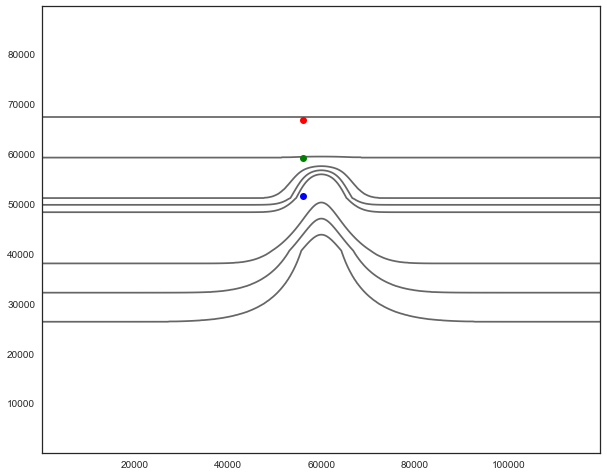

In [5]:
sns.set_style(style='white')
fig, ax = plt.subplots(1, 1, figsize=(10,8))

ax.contour(grid.X,grid.Y,grid.Depth,[50,100,150,200,250,600,800,1000], colors='0.4')
ax.plot(grid.X[150],grid.Y[227], 'bo')
ax.plot(grid.X[150],grid.Y[267], 'go')
ax.plot(grid.X[150],grid.Y[297], 'ro')

In [6]:
advCS1_flux03 = calc_trac_transport_CS(unstagger_xarray(flux03.ADVyTr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS2_flux03 = calc_trac_transport_CS(unstagger_xarray(flux03.ADVyTr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS3_flux03 = calc_trac_transport_CS(unstagger_xarray(flux03.ADVyTr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS4_flux03 = calc_trac_transport_CS(unstagger_xarray(flux03.ADVyTr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS5_flux03 = calc_trac_transport_CS(unstagger_xarray(flux03.ADVyTr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')

advCS1_flux14 = calc_trac_transport_CS(unstagger_xarray(flux14.ADVyTr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS2_flux14 = calc_trac_transport_CS(unstagger_xarray(flux14.ADVyTr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS3_flux14 = calc_trac_transport_CS(unstagger_xarray(flux14.ADVyTr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS4_flux14 = calc_trac_transport_CS(unstagger_xarray(flux14.ADVyTr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS5_flux14 = calc_trac_transport_CS(unstagger_xarray(flux14.ADVyTr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')

advCS1_flux15 = calc_trac_transport_CS(unstagger_xarray(flux15.ADVyTr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS2_flux15 = calc_trac_transport_CS(unstagger_xarray(flux15.ADVyTr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS3_flux15 = calc_trac_transport_CS(unstagger_xarray(flux15.ADVyTr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS4_flux15 = calc_trac_transport_CS(unstagger_xarray(flux15.ADVyTr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS5_flux15 = calc_trac_transport_CS(unstagger_xarray(flux15.ADVyTr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')

advCS1_flux16 = calc_trac_transport_CS(unstagger_xarray(flux16.ADVyTr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS2_flux16 = calc_trac_transport_CS(unstagger_xarray(flux16.ADVyTr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS3_flux16 = calc_trac_transport_CS(unstagger_xarray(flux16.ADVyTr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS4_flux16 = calc_trac_transport_CS(unstagger_xarray(flux16.ADVyTr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS5_flux16 = calc_trac_transport_CS(unstagger_xarray(flux16.ADVyTr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')

advCS1_flux18 = calc_trac_transport_CS(unstagger_xarray(flux18.ADVyTr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS2_flux18 = calc_trac_transport_CS(unstagger_xarray(flux18.ADVyTr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS3_flux18 = calc_trac_transport_CS(unstagger_xarray(flux18.ADVyTr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS4_flux18 = calc_trac_transport_CS(unstagger_xarray(flux18.ADVyTr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS5_flux18 = calc_trac_transport_CS(unstagger_xarray(flux18.ADVyTr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')

advCS1_flux19 = calc_trac_transport_CS(unstagger_xarray(flux19.ADVyTr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS2_flux19 = calc_trac_transport_CS(unstagger_xarray(flux19.ADVyTr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS3_flux19 = calc_trac_transport_CS(unstagger_xarray(flux19.ADVyTr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS4_flux19 = calc_trac_transport_CS(unstagger_xarray(flux19.ADVyTr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS5_flux19 = calc_trac_transport_CS(unstagger_xarray(flux19.ADVyTr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')

In [7]:
advCS1_flux07 = calc_trac_transport_CS(unstagger_xarray(flux07.ADVyTr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS2_flux07 = calc_trac_transport_CS(unstagger_xarray(flux07.ADVyTr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS3_flux07 = calc_trac_transport_CS(unstagger_xarray(flux07.ADVyTr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS4_flux07 = calc_trac_transport_CS(unstagger_xarray(flux07.ADVyTr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS5_flux07 = calc_trac_transport_CS(unstagger_xarray(flux07.ADVyTr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')

advCS1_flux26 = calc_trac_transport_CS(unstagger_xarray(flux26.ADVyTr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS2_flux26 = calc_trac_transport_CS(unstagger_xarray(flux26.ADVyTr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS3_flux26 = calc_trac_transport_CS(unstagger_xarray(flux26.ADVyTr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS4_flux26 = calc_trac_transport_CS(unstagger_xarray(flux26.ADVyTr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS5_flux26 = calc_trac_transport_CS(unstagger_xarray(flux26.ADVyTr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')

advCS1_flux27 = calc_trac_transport_CS(unstagger_xarray(flux27.ADVyTr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS2_flux27 = calc_trac_transport_CS(unstagger_xarray(flux27.ADVyTr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS3_flux27 = calc_trac_transport_CS(unstagger_xarray(flux27.ADVyTr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS4_flux27 = calc_trac_transport_CS(unstagger_xarray(flux27.ADVyTr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS5_flux27 = calc_trac_transport_CS(unstagger_xarray(flux27.ADVyTr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')

advCS1_flux28 = calc_trac_transport_CS(unstagger_xarray(flux28.ADVyTr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS2_flux28 = calc_trac_transport_CS(unstagger_xarray(flux28.ADVyTr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS3_flux28 = calc_trac_transport_CS(unstagger_xarray(flux28.ADVyTr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS4_flux28 = calc_trac_transport_CS(unstagger_xarray(flux28.ADVyTr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS5_flux28 = calc_trac_transport_CS(unstagger_xarray(flux28.ADVyTr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')

advCS1_flux22 = calc_trac_transport_CS(unstagger_xarray(flux22.ADVyTr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS2_flux22 = calc_trac_transport_CS(unstagger_xarray(flux22.ADVyTr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS3_flux22 = calc_trac_transport_CS(unstagger_xarray(flux22.ADVyTr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS4_flux22 = calc_trac_transport_CS(unstagger_xarray(flux22.ADVyTr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS5_flux22 = calc_trac_transport_CS(unstagger_xarray(flux22.ADVyTr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')

advCS1_flux23 = calc_trac_transport_CS(unstagger_xarray(flux23.ADVyTr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS2_flux23 = calc_trac_transport_CS(unstagger_xarray(flux23.ADVyTr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS3_flux23 = calc_trac_transport_CS(unstagger_xarray(flux23.ADVyTr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS4_flux23 = calc_trac_transport_CS(unstagger_xarray(flux23.ADVyTr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS5_flux23 = calc_trac_transport_CS(unstagger_xarray(flux23.ADVyTr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')

In [8]:
difCS1_flux03 = calc_trac_transport_CS(unstagger_xarray(flux03.DFyETr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS2_flux03 = calc_trac_transport_CS(unstagger_xarray(flux03.DFyETr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS3_flux03 = calc_trac_transport_CS(unstagger_xarray(flux03.DFyETr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS4_flux03 = calc_trac_transport_CS(unstagger_xarray(flux03.DFyETr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS5_flux03 = calc_trac_transport_CS(unstagger_xarray(flux03.DFyETr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')

difCS1_flux14 = calc_trac_transport_CS(unstagger_xarray(flux14.DFyETr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS2_flux14 = calc_trac_transport_CS(unstagger_xarray(flux14.DFyETr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS3_flux14 = calc_trac_transport_CS(unstagger_xarray(flux14.DFyETr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS4_flux14 = calc_trac_transport_CS(unstagger_xarray(flux14.DFyETr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS5_flux14 = calc_trac_transport_CS(unstagger_xarray(flux14.DFyETr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')

difCS1_flux15 = calc_trac_transport_CS(unstagger_xarray(flux15.DFyETr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS2_flux15 = calc_trac_transport_CS(unstagger_xarray(flux15.DFyETr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS3_flux15 = calc_trac_transport_CS(unstagger_xarray(flux15.DFyETr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS4_flux15 = calc_trac_transport_CS(unstagger_xarray(flux15.DFyETr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS5_flux15 = calc_trac_transport_CS(unstagger_xarray(flux15.DFyETr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')

difCS1_flux16 = calc_trac_transport_CS(unstagger_xarray(flux16.DFyETr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS2_flux16 = calc_trac_transport_CS(unstagger_xarray(flux16.DFyETr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS3_flux16 = calc_trac_transport_CS(unstagger_xarray(flux16.DFyETr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS4_flux16 = calc_trac_transport_CS(unstagger_xarray(flux16.DFyETr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS5_flux16 = calc_trac_transport_CS(unstagger_xarray(flux16.DFyETr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')

difCS1_flux18 = calc_trac_transport_CS(unstagger_xarray(flux18.DFyETr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS2_flux18 = calc_trac_transport_CS(unstagger_xarray(flux18.DFyETr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS3_flux18 = calc_trac_transport_CS(unstagger_xarray(flux18.DFyETr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS4_flux18 = calc_trac_transport_CS(unstagger_xarray(flux18.DFyETr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS5_flux18 = calc_trac_transport_CS(unstagger_xarray(flux18.DFyETr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')

In [9]:
difCS1_flux07 = calc_trac_transport_CS(unstagger_xarray(flux07.DFyETr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS2_flux07 = calc_trac_transport_CS(unstagger_xarray(flux07.DFyETr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS3_flux07 = calc_trac_transport_CS(unstagger_xarray(flux07.DFyETr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS4_flux07 = calc_trac_transport_CS(unstagger_xarray(flux07.DFyETr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS5_flux07 = calc_trac_transport_CS(unstagger_xarray(flux07.DFyETr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')

difCS1_flux26 = calc_trac_transport_CS(unstagger_xarray(flux26.DFyETr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS2_flux26 = calc_trac_transport_CS(unstagger_xarray(flux26.DFyETr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS3_flux26 = calc_trac_transport_CS(unstagger_xarray(flux26.DFyETr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS4_flux26 = calc_trac_transport_CS(unstagger_xarray(flux26.DFyETr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS5_flux26 = calc_trac_transport_CS(unstagger_xarray(flux26.DFyETr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')

difCS1_flux27 = calc_trac_transport_CS(unstagger_xarray(flux27.DFyETr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS2_flux27 = calc_trac_transport_CS(unstagger_xarray(flux27.DFyETr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS3_flux27 = calc_trac_transport_CS(unstagger_xarray(flux27.DFyETr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS4_flux27 = calc_trac_transport_CS(unstagger_xarray(flux27.DFyETr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS5_flux27 = calc_trac_transport_CS(unstagger_xarray(flux27.DFyETr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')

difCS1_flux28 = calc_trac_transport_CS(unstagger_xarray(flux28.DFyETr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS2_flux28 = calc_trac_transport_CS(unstagger_xarray(flux28.DFyETr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS3_flux28 = calc_trac_transport_CS(unstagger_xarray(flux28.DFyETr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS4_flux28 = calc_trac_transport_CS(unstagger_xarray(flux28.DFyETr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS5_flux28 = calc_trac_transport_CS(unstagger_xarray(flux28.DFyETr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')

difCS1_flux22 = calc_trac_transport_CS(unstagger_xarray(flux22.DFyETr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS2_flux22 = calc_trac_transport_CS(unstagger_xarray(flux22.DFyETr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS3_flux22 = calc_trac_transport_CS(unstagger_xarray(flux22.DFyETr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS4_flux22 = calc_trac_transport_CS(unstagger_xarray(flux22.DFyETr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS5_flux22 = calc_trac_transport_CS(unstagger_xarray(flux22.DFyETr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')

difCS1_flux23 = calc_trac_transport_CS(unstagger_xarray(flux23.DFyETr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS2_flux23 = calc_trac_transport_CS(unstagger_xarray(flux23.DFyETr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS3_flux23 = calc_trac_transport_CS(unstagger_xarray(flux23.DFyETr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS4_flux23 = calc_trac_transport_CS(unstagger_xarray(flux23.DFyETr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS5_flux23 = calc_trac_transport_CS(unstagger_xarray(flux23.DFyETr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')

### Cross-shelf sections

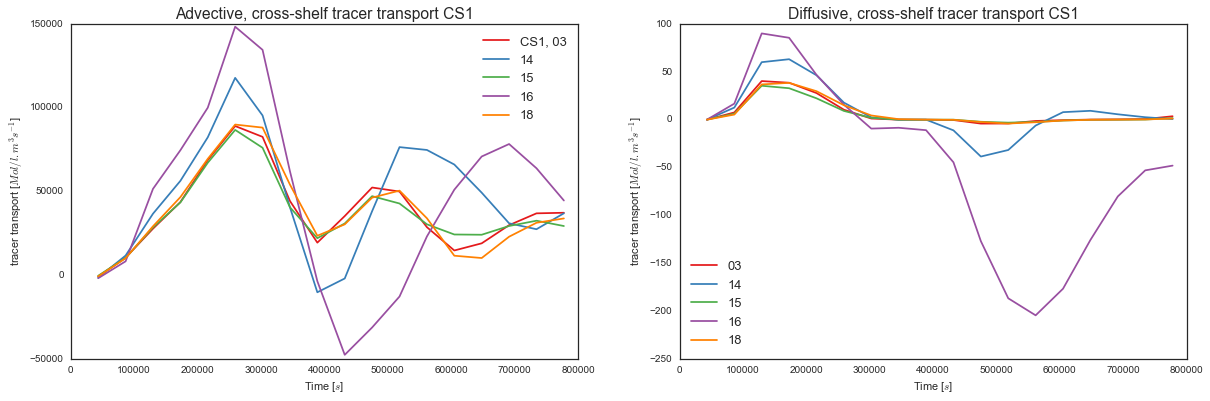

In [10]:
sns.set_palette('Set1')
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

(advCS1_flux03).plot(ax=ax[0], label = 'CS1, 03')
(advCS1_flux14).plot(ax=ax[0], label = '14')
(advCS1_flux15).plot(ax=ax[0], label = '15')
(advCS1_flux16).plot(ax=ax[0], label = '16')
(advCS1_flux18).plot(ax=ax[0], label = '18') 


(difCS1_flux03).plot(ax=ax[1], label = '03')
(difCS1_flux14).plot(ax=ax[1], label = '14')
(difCS1_flux15).plot(ax=ax[1], label = '15')
(difCS1_flux16).plot(ax=ax[1], label = '16')
(difCS1_flux18).plot(ax=ax[1], label = '18') 


ax[0] = fig_looks(ax[0],title='Advective, cross-shelf tracer transport CS1')
ax[1] = fig_looks(ax[1],title='Diffusive, cross-shelf tracer transport CS1')

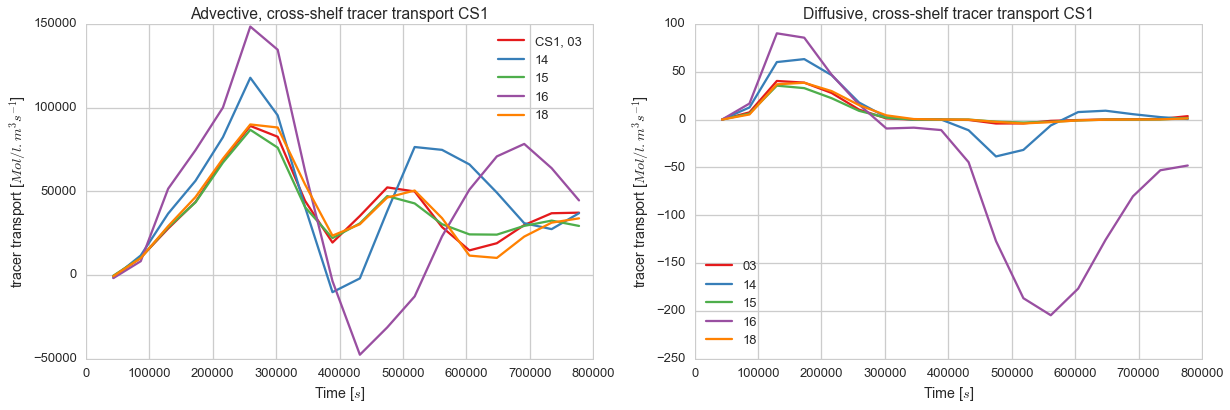

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

(advCS1_flux03).plot(ax=ax[0], label = 'CS1, 03')
(advCS1_flux14).plot(ax=ax[0], label = '14')
(advCS1_flux15).plot(ax=ax[0], label = '15')
(advCS1_flux16).plot(ax=ax[0], label = '16')
(advCS1_flux18).plot(ax=ax[0], label = '18') 


(difCS1_flux03).plot(ax=ax[1], label = '03')
(difCS1_flux14).plot(ax=ax[1], label = '14')
(difCS1_flux15).plot(ax=ax[1], label = '15')
(difCS1_flux16).plot(ax=ax[1], label = '16')
(difCS1_flux18).plot(ax=ax[1], label = '18') 


ax[0] = fig_looks(ax[0],title='Advective, cross-shelf tracer transport CS1')
ax[1] = fig_looks(ax[1],title='Diffusive, cross-shelf tracer transport CS1')

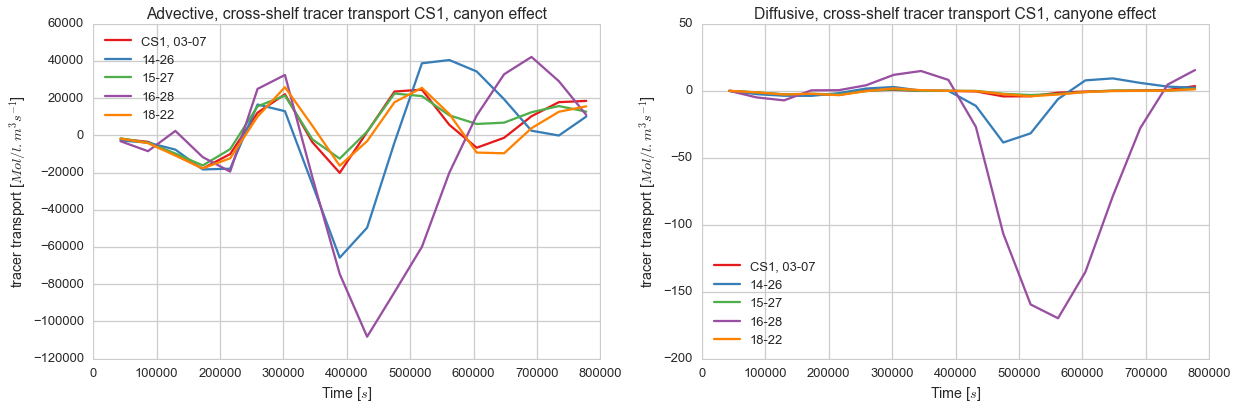

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

(advCS1_flux03-advCS1_flux07).plot(ax=ax[0], label = 'CS1, 03-07')
(advCS1_flux14-advCS1_flux26).plot(ax=ax[0], label = '14-26')
(advCS1_flux15-advCS1_flux27).plot(ax=ax[0], label = '15-27')
(advCS1_flux16-advCS1_flux28).plot(ax=ax[0], label = '16-28')
(advCS1_flux18-advCS1_flux22).plot(ax=ax[0], label = '18-22') 


(difCS1_flux03-difCS1_flux07).plot(ax=ax[1], label = 'CS1, 03-07')
(difCS1_flux14-difCS1_flux26).plot(ax=ax[1], label = '14-26')
(difCS1_flux15-difCS1_flux27).plot(ax=ax[1], label = '15-27')
(difCS1_flux16-difCS1_flux28).plot(ax=ax[1], label = '16-28')
(difCS1_flux18-difCS1_flux22).plot(ax=ax[1], label = '18-22') 


ax[0] = fig_looks(ax[0],title='Advective, cross-shelf tracer transport CS1, canyon effect')
ax[1] = fig_looks(ax[1],title='Diffusive, cross-shelf tracer transport CS1, canyone effect')

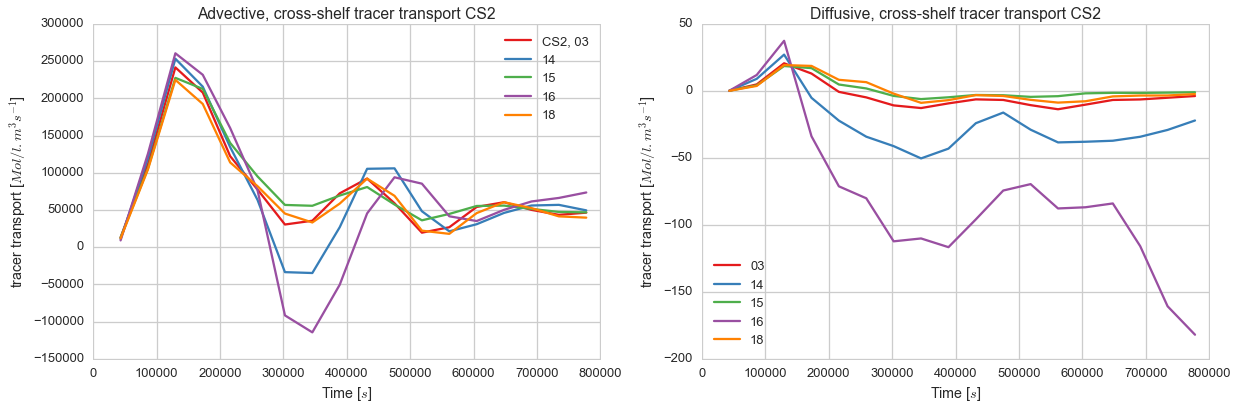

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

(advCS2_flux03).plot(ax=ax[0], label = 'CS2, 03')
(advCS2_flux14).plot(ax=ax[0], label = '14')
(advCS2_flux15).plot(ax=ax[0], label = '15')
(advCS2_flux16).plot(ax=ax[0], label = '16')
(advCS2_flux18).plot(ax=ax[0], label = '18') 


(difCS2_flux03).plot(ax=ax[1], label = '03')
(difCS2_flux14).plot(ax=ax[1], label = '14')
(difCS2_flux15).plot(ax=ax[1], label = '15')
(difCS2_flux16).plot(ax=ax[1], label = '16')
(difCS2_flux18).plot(ax=ax[1], label = '18') 


ax[0] = fig_looks(ax[0],title='Advective, cross-shelf tracer transport CS2')
ax[1] = fig_looks(ax[1],title='Diffusive, cross-shelf tracer transport CS2')

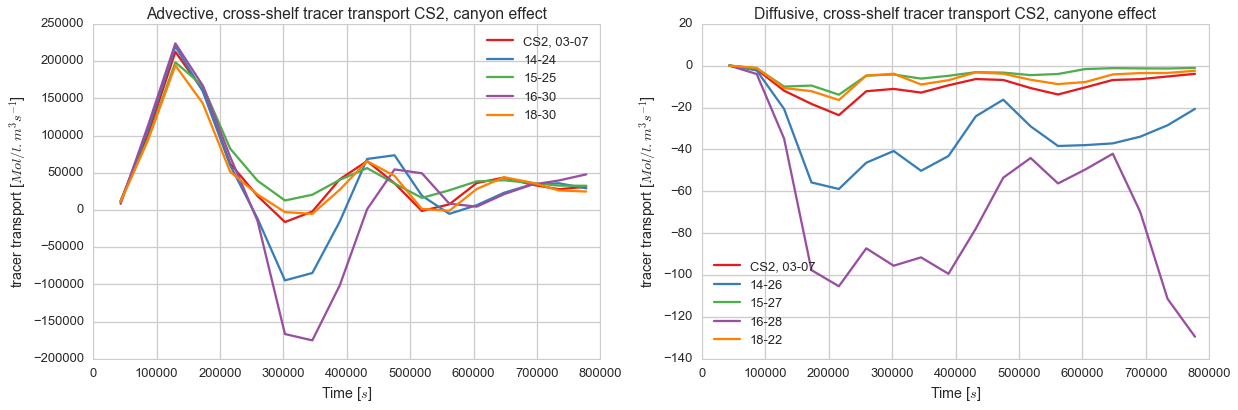

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

(advCS2_flux03-advCS2_flux07).plot(ax=ax[0], label = 'CS2, 03-07')
(advCS2_flux14-advCS2_flux26).plot(ax=ax[0], label = '14-24')
(advCS2_flux15-advCS2_flux27).plot(ax=ax[0], label = '15-25')
(advCS2_flux16-advCS2_flux28).plot(ax=ax[0], label = '16-30')
(advCS2_flux18-advCS2_flux22).plot(ax=ax[0], label = '18-30') 


(difCS2_flux03-difCS2_flux07).plot(ax=ax[1], label = 'CS2, 03-07')
(difCS2_flux14-difCS2_flux26).plot(ax=ax[1], label = '14-26')
(difCS2_flux15-difCS2_flux27).plot(ax=ax[1], label = '15-27')
(difCS2_flux16-difCS2_flux28).plot(ax=ax[1], label = '16-28')
(difCS2_flux18-difCS2_flux22).plot(ax=ax[1], label = '18-22') 


ax[0] = fig_looks(ax[0],title='Advective, cross-shelf tracer transport CS2, canyon effect')
ax[1] = fig_looks(ax[1],title='Diffusive, cross-shelf tracer transport CS2, canyone effect')

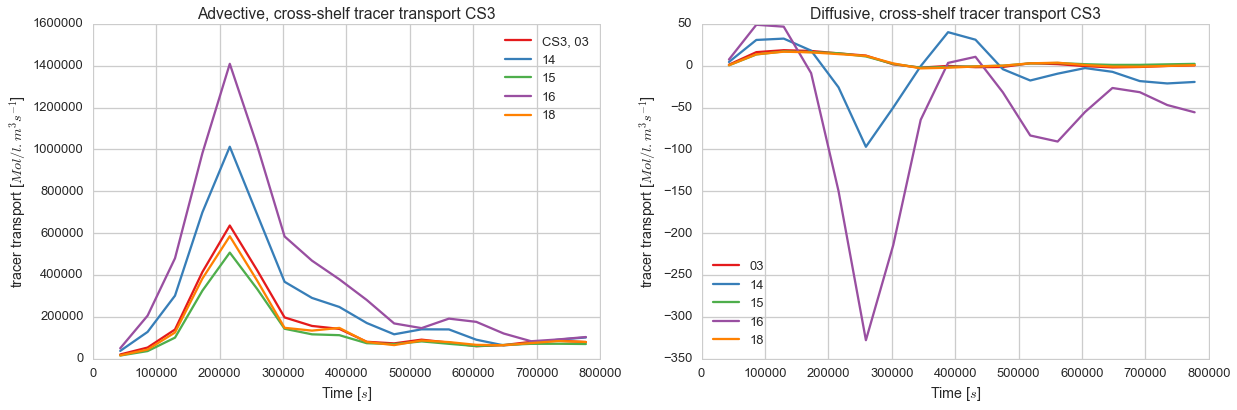

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

(advCS3_flux03).plot(ax=ax[0], label = 'CS3, 03')
(advCS3_flux14).plot(ax=ax[0], label = '14')
(advCS3_flux15).plot(ax=ax[0], label = '15')
(advCS3_flux16).plot(ax=ax[0], label = '16')
(advCS3_flux18).plot(ax=ax[0], label = '18') 


(difCS3_flux03).plot(ax=ax[1], label = '03')
(difCS3_flux14).plot(ax=ax[1], label = '14')
(difCS3_flux15).plot(ax=ax[1], label = '15')
(difCS3_flux16).plot(ax=ax[1], label = '16')
(difCS3_flux18).plot(ax=ax[1], label = '18') 


ax[0] = fig_looks(ax[0],title='Advective, cross-shelf tracer transport CS3')
ax[1] = fig_looks(ax[1],title='Diffusive, cross-shelf tracer transport CS3')

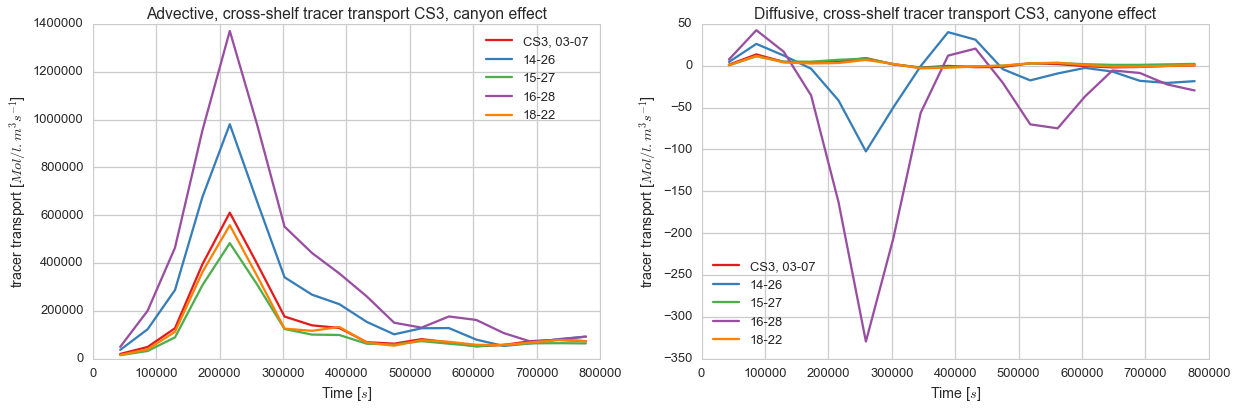

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

(advCS3_flux03-advCS3_flux07).plot(ax=ax[0], label = 'CS3, 03-07')
(advCS3_flux14-advCS3_flux26).plot(ax=ax[0], label = '14-26')
(advCS3_flux15-advCS3_flux27).plot(ax=ax[0], label = '15-27')
(advCS3_flux16-advCS3_flux28).plot(ax=ax[0], label = '16-28')
(advCS3_flux18-advCS3_flux22).plot(ax=ax[0], label = '18-22') 


(difCS3_flux03-difCS3_flux07).plot(ax=ax[1], label = 'CS3, 03-07')
(difCS3_flux14-difCS3_flux26).plot(ax=ax[1], label = '14-26')
(difCS3_flux15-difCS3_flux27).plot(ax=ax[1], label = '15-27')
(difCS3_flux16-difCS3_flux28).plot(ax=ax[1], label = '16-28')
(difCS3_flux18-difCS3_flux22).plot(ax=ax[1], label = '18-22') 


ax[0] = fig_looks(ax[0],title='Advective, cross-shelf tracer transport CS3, canyon effect')
ax[1] = fig_looks(ax[1],title='Diffusive, cross-shelf tracer transport CS3, canyone effect')

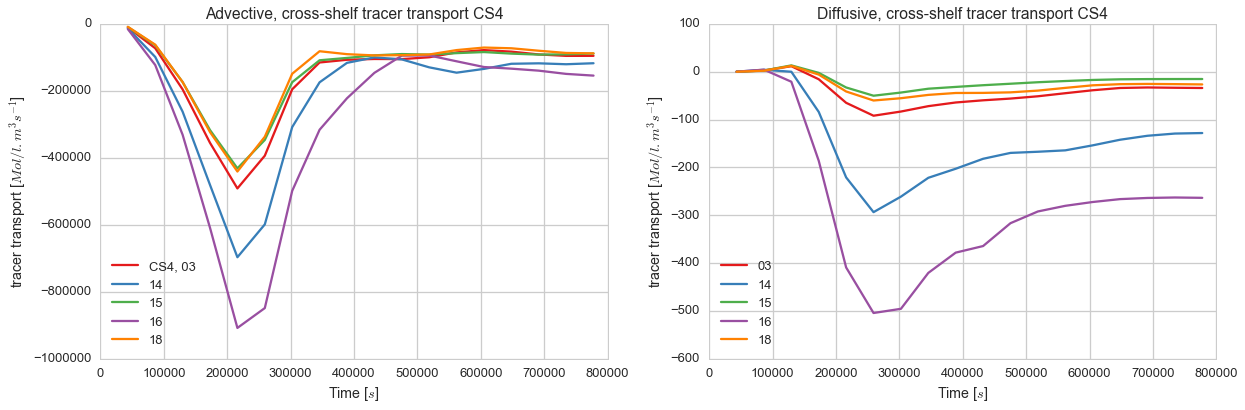

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

(advCS4_flux03).plot(ax=ax[0], label = 'CS4, 03')
(advCS4_flux14).plot(ax=ax[0], label = '14')
(advCS4_flux15).plot(ax=ax[0], label = '15')
(advCS4_flux16).plot(ax=ax[0], label = '16')
(advCS4_flux18).plot(ax=ax[0], label = '18') 


(difCS4_flux03).plot(ax=ax[1], label = '03')
(difCS4_flux14).plot(ax=ax[1], label = '14')
(difCS4_flux15).plot(ax=ax[1], label = '15')
(difCS4_flux16).plot(ax=ax[1], label = '16')
(difCS4_flux18).plot(ax=ax[1], label = '18') 


ax[0] = fig_looks(ax[0],title='Advective, cross-shelf tracer transport CS4')
ax[1] = fig_looks(ax[1],title='Diffusive, cross-shelf tracer transport CS4')

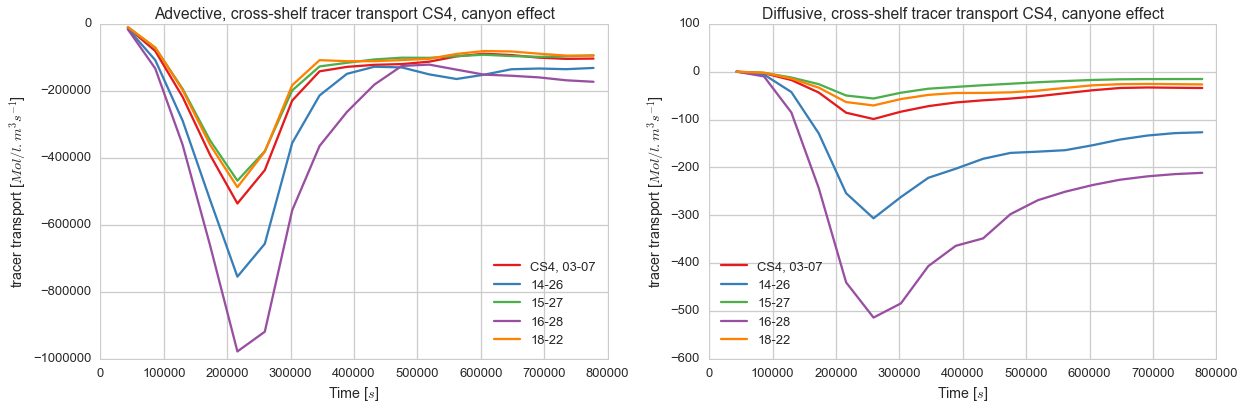

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

(advCS4_flux03-advCS4_flux07).plot(ax=ax[0], label = 'CS4, 03-07')
(advCS4_flux14-advCS4_flux26).plot(ax=ax[0], label = '14-26')
(advCS4_flux15-advCS4_flux27).plot(ax=ax[0], label = '15-27')
(advCS4_flux16-advCS4_flux28).plot(ax=ax[0], label = '16-28')
(advCS4_flux18-advCS4_flux22).plot(ax=ax[0], label = '18-22') 


(difCS4_flux03-difCS4_flux07).plot(ax=ax[1], label = 'CS4, 03-07')
(difCS4_flux14-difCS4_flux26).plot(ax=ax[1], label = '14-26')
(difCS4_flux15-difCS4_flux27).plot(ax=ax[1], label = '15-27')
(difCS4_flux16-difCS4_flux28).plot(ax=ax[1], label = '16-28')
(difCS4_flux18-difCS4_flux22).plot(ax=ax[1], label = '18-22') 


ax[0] = fig_looks(ax[0],title='Advective, cross-shelf tracer transport CS4, canyon effect')
ax[1] = fig_looks(ax[1],title='Diffusive, cross-shelf tracer transport CS4, canyone effect')

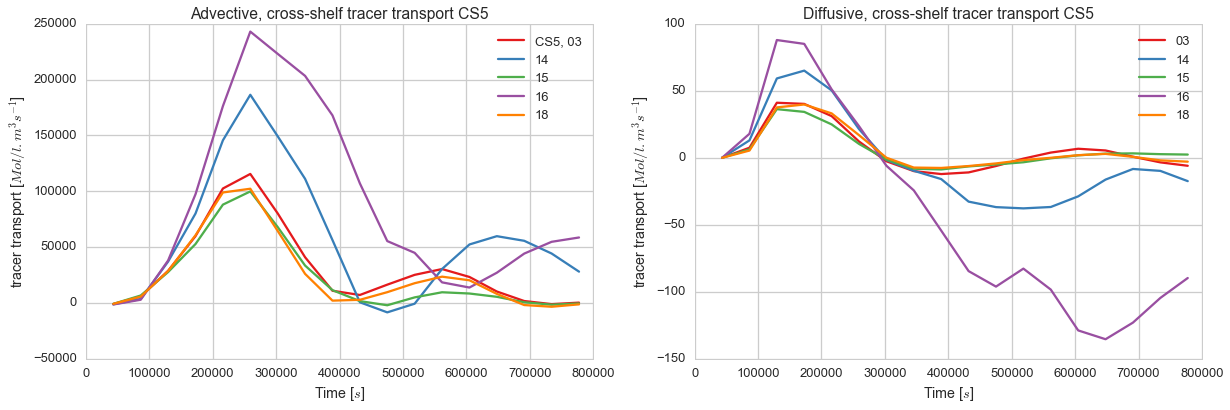

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

(advCS5_flux03).plot(ax=ax[0], label = 'CS5, 03')
(advCS5_flux14).plot(ax=ax[0], label = '14')
(advCS5_flux15).plot(ax=ax[0], label = '15')
(advCS5_flux16).plot(ax=ax[0], label = '16')
(advCS5_flux18).plot(ax=ax[0], label = '18') 


(difCS5_flux03).plot(ax=ax[1], label = '03')
(difCS5_flux14).plot(ax=ax[1], label = '14')
(difCS5_flux15).plot(ax=ax[1], label = '15')
(difCS5_flux16).plot(ax=ax[1], label = '16')
(difCS5_flux18).plot(ax=ax[1], label = '18') 


ax[0] = fig_looks(ax[0],title='Advective, cross-shelf tracer transport CS5')
ax[1] = fig_looks(ax[1],title='Diffusive, cross-shelf tracer transport CS5')

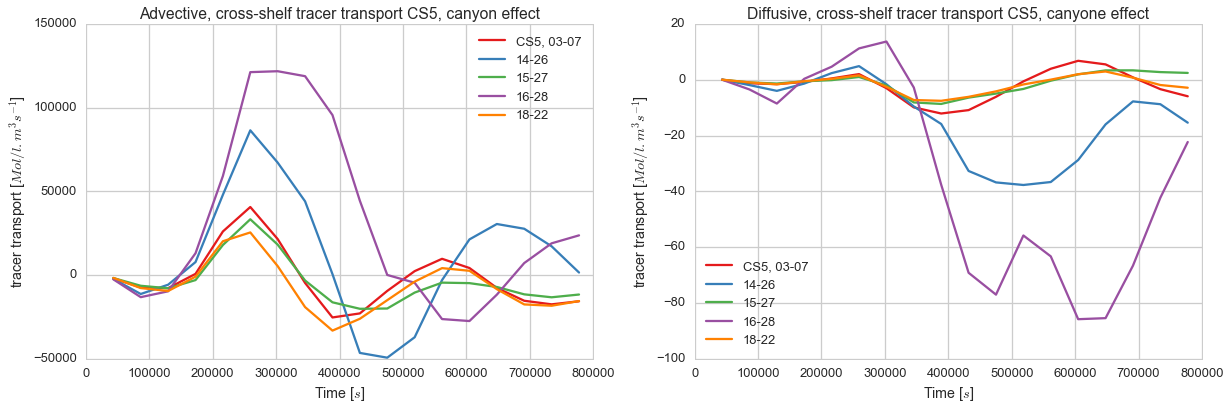

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

(advCS5_flux03-advCS5_flux07).plot(ax=ax[0], label = 'CS5, 03-07')
(advCS5_flux14-advCS5_flux26).plot(ax=ax[0], label = '14-26')
(advCS5_flux15-advCS5_flux27).plot(ax=ax[0], label = '15-27')
(advCS5_flux16-advCS5_flux28).plot(ax=ax[0], label = '16-28')
(advCS5_flux18-advCS5_flux22).plot(ax=ax[0], label = '18-22') 


(difCS5_flux03-difCS5_flux07).plot(ax=ax[1], label = 'CS5, 03-07')
(difCS5_flux14-difCS5_flux26).plot(ax=ax[1], label = '14-26')
(difCS5_flux15-difCS5_flux27).plot(ax=ax[1], label = '15-27')
(difCS5_flux16-difCS5_flux28).plot(ax=ax[1], label = '16-28')
(difCS5_flux18-difCS5_flux22).plot(ax=ax[1], label = '18-22') 


ax[0] = fig_looks(ax[0],title='Advective, cross-shelf tracer transport CS5, canyon effect')
ax[1] = fig_looks(ax[1],title='Diffusive, cross-shelf tracer transport CS5, canyone effect')

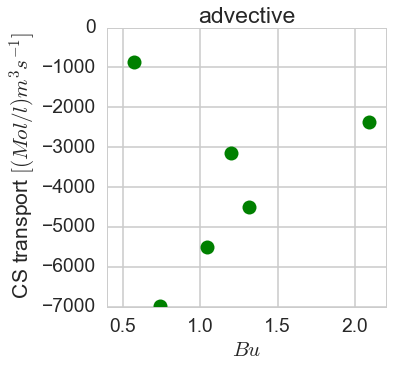

In [26]:
sns.set_context('poster',font_scale=1.2)

total03 = (advCS5_flux03 + advCS4_flux03 + advCS3_flux03 + advCS2_flux03 + advCS1_flux03-
           (advCS5_flux07 + advCS4_flux07 + advCS3_flux07 + advCS2_flux07 + advCS1_flux07)).isel(T=slice(6,19)).mean(dim='T')
total14 = (advCS5_flux14 + advCS4_flux14 + advCS3_flux14 + advCS2_flux14 + advCS1_flux14-
           (advCS5_flux26 + advCS4_flux26 + advCS3_flux26 + advCS2_flux26 + advCS1_flux26)).isel(T=slice(6,19)).mean(dim='T')
total15 = (advCS5_flux15 + advCS4_flux15 + advCS3_flux15 + advCS2_flux15 + advCS1_flux15-
           (advCS5_flux27 + advCS4_flux27 + advCS3_flux27 + advCS2_flux27 + advCS1_flux27)).isel(T=slice(6,19)).mean(dim='T')
total16 = (advCS5_flux16 + advCS4_flux16 + advCS3_flux16 + advCS2_flux16 + advCS1_flux16-
           (advCS5_flux28 + advCS4_flux28 + advCS3_flux28 + advCS2_flux28 + advCS1_flux28)).isel(T=slice(6,19)).mean(dim='T')

total18 = (advCS5_flux18 + advCS4_flux18 + advCS3_flux18 + advCS2_flux18 + advCS1_flux18-
           (advCS5_flux22 + advCS4_flux22 + advCS3_flux22 + advCS2_flux22 + advCS1_flux22)).isel(T=slice(6,19)).mean(dim='T')

total19 = (advCS5_flux19 + advCS4_flux19 + advCS3_flux19 + advCS2_flux19 + advCS1_flux19-
           (advCS5_flux23 + advCS4_flux23 + advCS3_flux23 + advCS2_flux23 + advCS1_flux23)).isel(T=slice(6,19)).mean(dim='T')

datasets = [total03,total14,total15,total16,total18, total19]

Hs = 152.5 # m
W = 8300.0 # m
N = np.array([5.5E-3,3.9E-3,6.3E-3,3.0E-3,5.5E-3,5.5E-3])
f = np.array([9.66E-5,9.66E-5,9.66E-5,9.66E-5,7.68E-5,4.84E-5])

Bu = (N*Hs)/(f*W)

fig,ax = plt.subplots(1,1,figsize=(5,5))

for data,ii in zip(datasets,range(len(Bu)+1)):
    
    ax.plot(Bu[ii],data,'go',markersize=14)
    
ax.set_ylabel(' CS transport $[(Mol/l)m^3s^{-1}]$')
ax.set_xlabel('$Bu$')
ax.set_title('advective')


plt.tight_layout
plt.plot()

fig.savefig('adv_trac_trans_Nf.eps',format='eps',transparent=True,frameon=False,bbox_inches='tight')


## Alongshore transports

### Downstream, near canyon rim

In [5]:
advAS1c_flux03 = calc_trac_transport_AS(unstagger_xarray(flux03.ADVxTr01,'Xp1'), AS1c_x_ind, AS1_y_slice, 'Y')
advAS2c_flux03 = calc_trac_transport_AS(unstagger_xarray(flux03.ADVxTr01,'Xp1'), AS1c_x_ind, AS2_y_slice, 'Y')
advAS3c_flux03 = calc_trac_transport_AS(unstagger_xarray(flux03.ADVxTr01,'Xp1'), AS1c_x_ind, AS3_y_slice, 'Y')

difAS1c_flux03 = calc_trac_transport_AS(unstagger_xarray(flux03.DFxETr01,'Xp1'), AS1c_x_ind, AS1_y_slice, 'Y')
difAS2c_flux03 = calc_trac_transport_AS(unstagger_xarray(flux03.DFxETr01,'Xp1'), AS1c_x_ind, AS2_y_slice, 'Y')
difAS3c_flux03 = calc_trac_transport_AS(unstagger_xarray(flux03.DFxETr01,'Xp1'), AS1c_x_ind, AS3_y_slice, 'Y')

advAS1c_flux14 = calc_trac_transport_AS(unstagger_xarray(flux14.ADVxTr01,'Xp1'), AS1c_x_ind, AS1_y_slice, 'Y')
advAS2c_flux14 = calc_trac_transport_AS(unstagger_xarray(flux14.ADVxTr01,'Xp1'), AS1c_x_ind, AS2_y_slice, 'Y')
advAS3c_flux14 = calc_trac_transport_AS(unstagger_xarray(flux14.ADVxTr01,'Xp1'), AS1c_x_ind, AS3_y_slice, 'Y')

difAS1c_flux14 = calc_trac_transport_AS(unstagger_xarray(flux14.DFxETr01,'Xp1'), AS1c_x_ind, AS1_y_slice, 'Y')
difAS2c_flux14 = calc_trac_transport_AS(unstagger_xarray(flux14.DFxETr01,'Xp1'), AS1c_x_ind, AS2_y_slice, 'Y')
difAS3c_flux14 = calc_trac_transport_AS(unstagger_xarray(flux14.DFxETr01,'Xp1'), AS1c_x_ind, AS3_y_slice, 'Y')

advAS1c_flux15 = calc_trac_transport_AS(unstagger_xarray(flux15.ADVxTr01,'Xp1'), AS1c_x_ind, AS1_y_slice, 'Y')
advAS2c_flux15 = calc_trac_transport_AS(unstagger_xarray(flux15.ADVxTr01,'Xp1'), AS1c_x_ind, AS2_y_slice, 'Y')
advAS3c_flux15 = calc_trac_transport_AS(unstagger_xarray(flux15.ADVxTr01,'Xp1'), AS1c_x_ind, AS3_y_slice, 'Y')

difAS1c_flux15 = calc_trac_transport_AS(unstagger_xarray(flux15.DFxETr01,'Xp1'), AS1c_x_ind, AS1_y_slice, 'Y')
difAS2c_flux15 = calc_trac_transport_AS(unstagger_xarray(flux15.DFxETr01,'Xp1'), AS1c_x_ind, AS2_y_slice, 'Y')
difAS3c_flux15 = calc_trac_transport_AS(unstagger_xarray(flux15.DFxETr01,'Xp1'), AS1c_x_ind, AS3_y_slice, 'Y')

advAS1c_flux16 = calc_trac_transport_AS(unstagger_xarray(flux16.ADVxTr01,'Xp1'), AS1c_x_ind, AS1_y_slice, 'Y')
advAS2c_flux16 = calc_trac_transport_AS(unstagger_xarray(flux16.ADVxTr01,'Xp1'), AS1c_x_ind, AS2_y_slice, 'Y')
advAS3c_flux16 = calc_trac_transport_AS(unstagger_xarray(flux16.ADVxTr01,'Xp1'), AS1c_x_ind, AS3_y_slice, 'Y')

difAS1c_flux16 = calc_trac_transport_AS(unstagger_xarray(flux16.DFxETr01,'Xp1'), AS1c_x_ind, AS1_y_slice, 'Y')
difAS2c_flux16 = calc_trac_transport_AS(unstagger_xarray(flux16.DFxETr01,'Xp1'), AS1c_x_ind, AS2_y_slice, 'Y')
difAS3c_flux16 = calc_trac_transport_AS(unstagger_xarray(flux16.DFxETr01,'Xp1'), AS1c_x_ind, AS3_y_slice, 'Y')

advAS1c_flux18 = calc_trac_transport_AS(unstagger_xarray(flux18.ADVxTr01,'Xp1'), AS1c_x_ind, AS1_y_slice, 'Y')
advAS2c_flux18 = calc_trac_transport_AS(unstagger_xarray(flux18.ADVxTr01,'Xp1'), AS1c_x_ind, AS2_y_slice, 'Y')
advAS3c_flux18 = calc_trac_transport_AS(unstagger_xarray(flux18.ADVxTr01,'Xp1'), AS1c_x_ind, AS3_y_slice, 'Y')

difAS1c_flux18 = calc_trac_transport_AS(unstagger_xarray(flux18.DFxETr01,'Xp1'), AS1c_x_ind, AS1_y_slice, 'Y')
difAS2c_flux18 = calc_trac_transport_AS(unstagger_xarray(flux18.DFxETr01,'Xp1'), AS1c_x_ind, AS2_y_slice, 'Y')
difAS3c_flux18 = calc_trac_transport_AS(unstagger_xarray(flux18.DFxETr01,'Xp1'), AS1c_x_ind, AS3_y_slice, 'Y')


In [6]:
advAS1c_flux07 = calc_trac_transport_AS(unstagger_xarray(flux07.ADVxTr01,'Xp1'), AS1c_x_ind, AS1_y_slice, 'Y')
advAS2c_flux07 = calc_trac_transport_AS(unstagger_xarray(flux07.ADVxTr01,'Xp1'), AS1c_x_ind, AS2_y_slice, 'Y')
advAS3c_flux07 = calc_trac_transport_AS(unstagger_xarray(flux07.ADVxTr01,'Xp1'), AS1c_x_ind, AS3_y_slice, 'Y')

difAS1c_flux07 = calc_trac_transport_AS(unstagger_xarray(flux07.DFxETr01,'Xp1'), AS1c_x_ind, AS1_y_slice, 'Y')
difAS2c_flux07 = calc_trac_transport_AS(unstagger_xarray(flux07.DFxETr01,'Xp1'), AS1c_x_ind, AS2_y_slice, 'Y')
difAS3c_flux07 = calc_trac_transport_AS(unstagger_xarray(flux07.DFxETr01,'Xp1'), AS1c_x_ind, AS3_y_slice, 'Y')

advAS1c_flux24 = calc_trac_transport_AS(unstagger_xarray(flux24.ADVxTr01,'Xp1'), AS1c_x_ind, AS1_y_slice, 'Y')
advAS2c_flux24 = calc_trac_transport_AS(unstagger_xarray(flux24.ADVxTr01,'Xp1'), AS1c_x_ind, AS2_y_slice, 'Y')
advAS3c_flux24 = calc_trac_transport_AS(unstagger_xarray(flux24.ADVxTr01,'Xp1'), AS1c_x_ind, AS3_y_slice, 'Y')

difAS1c_flux24 = calc_trac_transport_AS(unstagger_xarray(flux24.DFxETr01,'Xp1'), AS1c_x_ind, AS1_y_slice, 'Y')
difAS2c_flux24 = calc_trac_transport_AS(unstagger_xarray(flux24.DFxETr01,'Xp1'), AS1c_x_ind, AS2_y_slice, 'Y')
difAS3c_flux24 = calc_trac_transport_AS(unstagger_xarray(flux24.DFxETr01,'Xp1'), AS1c_x_ind, AS3_y_slice, 'Y')

advAS1c_flux25 = calc_trac_transport_AS(unstagger_xarray(flux25.ADVxTr01,'Xp1'), AS1c_x_ind, AS1_y_slice, 'Y')
advAS2c_flux25 = calc_trac_transport_AS(unstagger_xarray(flux25.ADVxTr01,'Xp1'), AS1c_x_ind, AS2_y_slice, 'Y')
advAS3c_flux25 = calc_trac_transport_AS(unstagger_xarray(flux25.ADVxTr01,'Xp1'), AS1c_x_ind, AS3_y_slice, 'Y')

difAS1c_flux25 = calc_trac_transport_AS(unstagger_xarray(flux25.DFxETr01,'Xp1'), AS1c_x_ind, AS1_y_slice, 'Y')
difAS2c_flux25 = calc_trac_transport_AS(unstagger_xarray(flux25.DFxETr01,'Xp1'), AS1c_x_ind, AS2_y_slice, 'Y')
difAS3c_flux25 = calc_trac_transport_AS(unstagger_xarray(flux25.DFxETr01,'Xp1'), AS1c_x_ind, AS3_y_slice, 'Y')

advAS1c_flux30 = calc_trac_transport_AS(unstagger_xarray(flux30.ADVxTr01,'Xp1'), AS1c_x_ind, AS1_y_slice, 'Y')
advAS2c_flux30 = calc_trac_transport_AS(unstagger_xarray(flux30.ADVxTr01,'Xp1'), AS1c_x_ind, AS2_y_slice, 'Y')
advAS3c_flux30 = calc_trac_transport_AS(unstagger_xarray(flux30.ADVxTr01,'Xp1'), AS1c_x_ind, AS3_y_slice, 'Y')

difAS1c_flux30 = calc_trac_transport_AS(unstagger_xarray(flux30.DFxETr01,'Xp1'), AS1c_x_ind, AS1_y_slice, 'Y')
difAS2c_flux30 = calc_trac_transport_AS(unstagger_xarray(flux30.DFxETr01,'Xp1'), AS1c_x_ind, AS2_y_slice, 'Y')
difAS3c_flux30 = calc_trac_transport_AS(unstagger_xarray(flux30.DFxETr01,'Xp1'), AS1c_x_ind, AS3_y_slice, 'Y')

advAS1c_flux30 = calc_trac_transport_AS(unstagger_xarray(flux30.ADVxTr01,'Xp1'), AS1c_x_ind, AS1_y_slice, 'Y')
advAS2c_flux30 = calc_trac_transport_AS(unstagger_xarray(flux30.ADVxTr01,'Xp1'), AS1c_x_ind, AS2_y_slice, 'Y')
advAS3c_flux30 = calc_trac_transport_AS(unstagger_xarray(flux30.ADVxTr01,'Xp1'), AS1c_x_ind, AS3_y_slice, 'Y')

difAS1c_flux30 = calc_trac_transport_AS(unstagger_xarray(flux30.DFxETr01,'Xp1'), AS1c_x_ind, AS1_y_slice, 'Y')
difAS2c_flux30 = calc_trac_transport_AS(unstagger_xarray(flux30.DFxETr01,'Xp1'), AS1c_x_ind, AS2_y_slice, 'Y')
difAS3c_flux30 = calc_trac_transport_AS(unstagger_xarray(flux30.DFxETr01,'Xp1'), AS1c_x_ind, AS3_y_slice, 'Y')


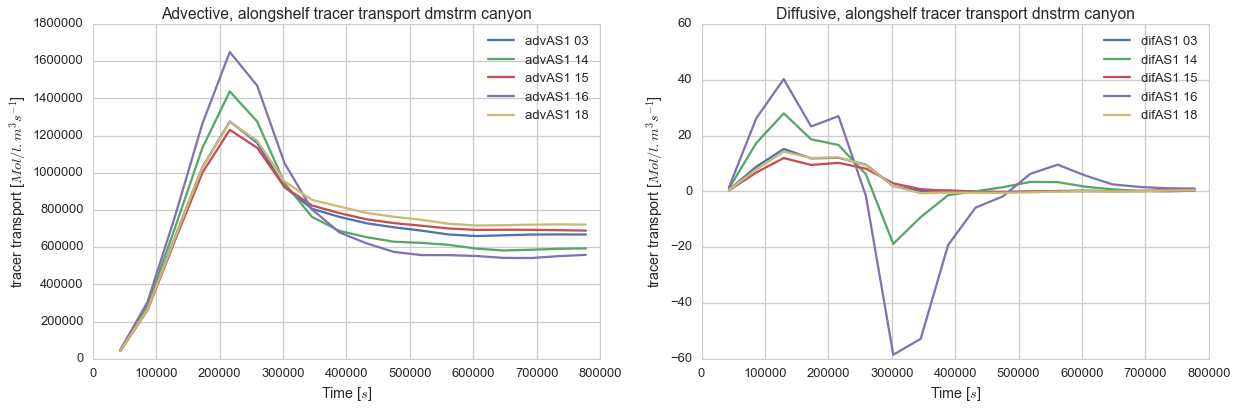

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

(advAS1c_flux03).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS1 03')
(advAS1c_flux14).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS1 14')
(advAS1c_flux15).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS1 15')
(advAS1c_flux16).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS1 16')
(advAS1c_flux18).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS1 18')

(difAS1c_flux03).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS1 03')
(difAS1c_flux14).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS1 14')
(difAS1c_flux15).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS1 15')
(difAS1c_flux16).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS1 16')
(difAS1c_flux18).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS1 18')


ax[0] = fig_looks(ax[0],title='Advective, alongshelf tracer transport dmstrm canyon')
ax[1] = fig_looks(ax[1],title='Diffusive, alongshelf tracer transport dnstrm canyon')

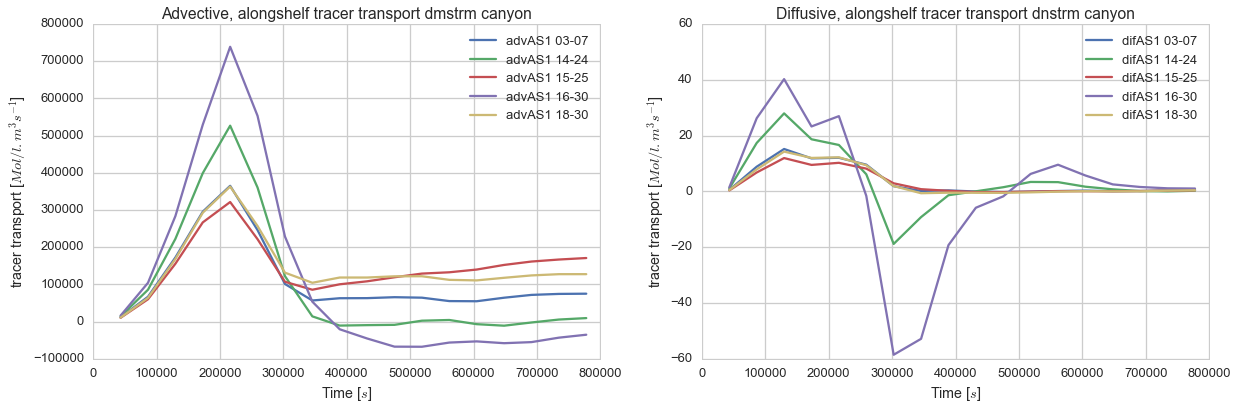

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

(advAS1c_flux03-advAS1c_flux07).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS1 03-07')
(advAS1c_flux14-advAS1c_flux24).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS1 14-24')
(advAS1c_flux15-advAS1c_flux25).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS1 15-25')
(advAS1c_flux16-advAS1c_flux30).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS1 16-30')
(advAS1c_flux18-advAS1c_flux30).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS1 18-30')

(difAS1c_flux03-difAS1c_flux07).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS1 03-07')
(difAS1c_flux14-difAS1c_flux24).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS1 14-24')
(difAS1c_flux15-difAS1c_flux25).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS1 15-25')
(difAS1c_flux16-difAS1c_flux30).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS1 16-30')
(difAS1c_flux18-difAS1c_flux30).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS1 18-30')


ax[0] = fig_looks(ax[0],title='Advective, alongshelf tracer transport dmstrm canyon')
ax[1] = fig_looks(ax[1],title='Diffusive, alongshelf tracer transport dnstrm canyon')

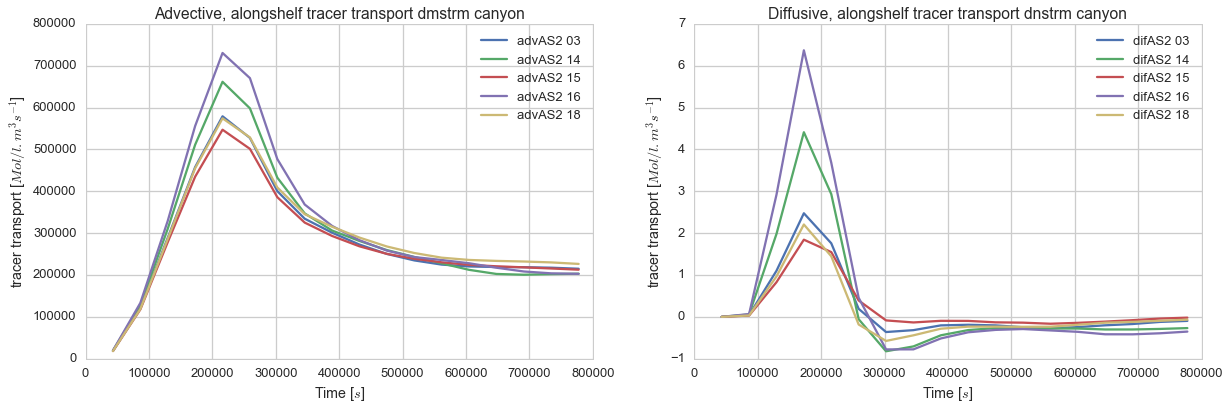

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

(advAS2c_flux03).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS2 03')
(advAS2c_flux14).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS2 14')
(advAS2c_flux15).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS2 15')
(advAS2c_flux16).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS2 16')
(advAS2c_flux18).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS2 18')

(difAS2c_flux03).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS2 03')
(difAS2c_flux14).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS2 14')
(difAS2c_flux15).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS2 15')
(difAS2c_flux16).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS2 16')
(difAS2c_flux18).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS2 18')


ax[0] = fig_looks(ax[0],title='Advective, alongshelf tracer transport dmstrm canyon')
ax[1] = fig_looks(ax[1],title='Diffusive, alongshelf tracer transport dnstrm canyon')

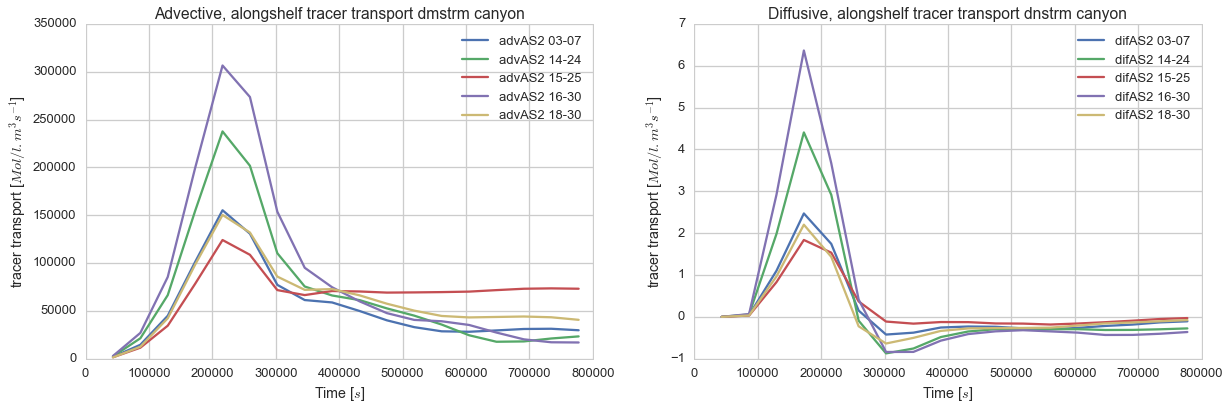

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

(advAS2c_flux03-advAS2c_flux07).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS2 03-07')
(advAS2c_flux14-advAS2c_flux24).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS2 14-24')
(advAS2c_flux15-advAS2c_flux25).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS2 15-25')
(advAS2c_flux16-advAS2c_flux30).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS2 16-30')
(advAS2c_flux18-advAS2c_flux30).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS2 18-30')

(difAS2c_flux03-difAS2c_flux07).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS2 03-07')
(difAS2c_flux14-difAS2c_flux24).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS2 14-24')
(difAS2c_flux15-difAS2c_flux25).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS2 15-25')
(difAS2c_flux16-difAS2c_flux30).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS2 16-30')
(difAS2c_flux18-difAS2c_flux30).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS2 18-30')


ax[0] = fig_looks(ax[0],title='Advective, alongshelf tracer transport dmstrm canyon')
ax[1] = fig_looks(ax[1],title='Diffusive, alongshelf tracer transport dnstrm canyon')

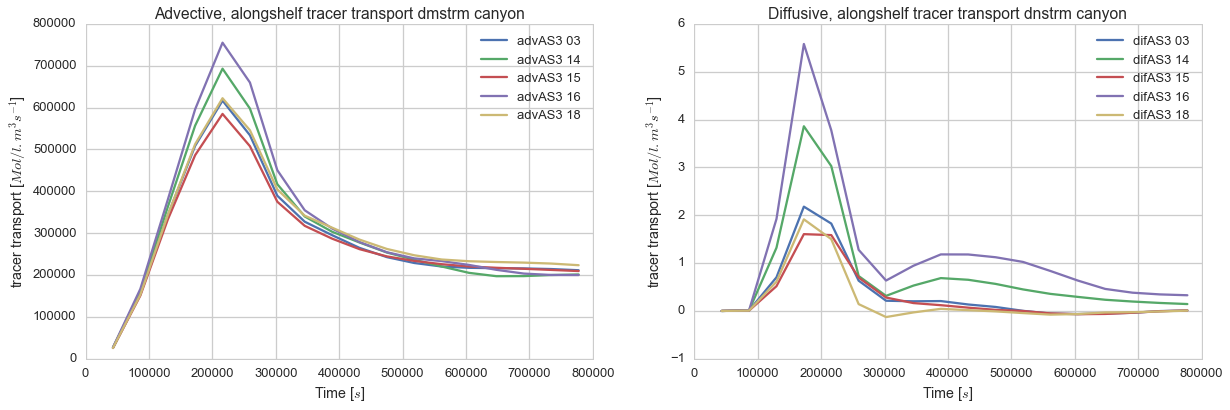

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

(advAS3c_flux03).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS3 03')
(advAS3c_flux14).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS3 14')
(advAS3c_flux15).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS3 15')
(advAS3c_flux16).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS3 16')
(advAS3c_flux18).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS3 18')

(difAS3c_flux03).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS3 03')
(difAS3c_flux14).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS3 14')
(difAS3c_flux15).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS3 15')
(difAS3c_flux16).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS3 16')
(difAS3c_flux18).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS3 18')


ax[0] = fig_looks(ax[0],title='Advective, alongshelf tracer transport dmstrm canyon')
ax[1] = fig_looks(ax[1],title='Diffusive, alongshelf tracer transport dnstrm canyon')

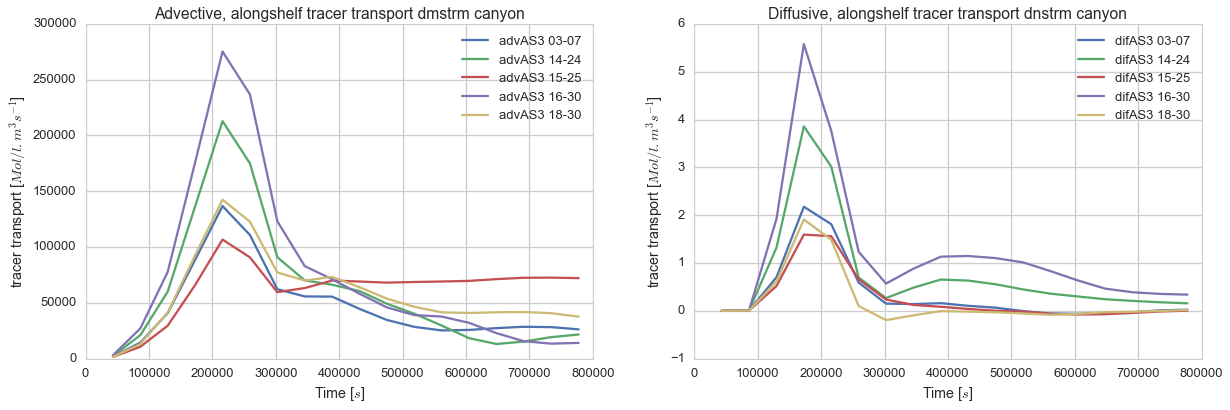

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

(advAS3c_flux03-advAS3c_flux07).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS3 03-07')
(advAS3c_flux14-advAS3c_flux24).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS3 14-24')
(advAS3c_flux15-advAS3c_flux25).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS3 15-25')
(advAS3c_flux16-advAS3c_flux30).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS3 16-30')
(advAS3c_flux18-advAS3c_flux30).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS3 18-30')

(difAS3c_flux03-difAS3c_flux07).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS3 03-07')
(difAS3c_flux14-difAS3c_flux24).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS3 14-24')
(difAS3c_flux15-difAS3c_flux25).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS3 15-25')
(difAS3c_flux16-difAS3c_flux30).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS3 16-30')
(difAS3c_flux18-difAS3c_flux30).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS3 18-30')


ax[0] = fig_looks(ax[0],title='Advective, alongshelf tracer transport dmstrm canyon')
ax[1] = fig_looks(ax[1],title='Diffusive, alongshelf tracer transport dnstrm canyon')

### Vertical transport at shelf break depth (only within the canyon)


In [8]:
advVR1_flux03 = (unstagger_xarray(flux03.ADVrTr01,'Zld000090').isel(Zld000090=30, X= slice(150,225), Y=slice(227,267))).sum(dim='X')
difEVR1_flux03 = (unstagger_xarray(flux03.DFrETr01,'Zld000090').isel(Zld000090=30, X= slice(150,225), Y=slice(227,267))).sum(dim='X')
difIVR1_flux03 = (unstagger_xarray(flux03.DFrITr01,'Zld000090').isel(Zld000090=30, X= slice(150,225), Y=slice(227,267))).sum(dim='X')

advVR1_flux14 = (unstagger_xarray(flux14.ADVrTr01,'Zld000090').isel(Zld000090=30, X= slice(150,225), Y=slice(227,267))).sum(dim='X')
difEVR1_flux14 = (unstagger_xarray(flux14.DFrETr01,'Zld000090').isel(Zld000090=30, X= slice(150,225), Y=slice(227,267))).sum(dim='X')
difIVR1_flux14 = (unstagger_xarray(flux14.DFrITr01,'Zld000090').isel(Zld000090=30, X= slice(150,225), Y=slice(227,267))).sum(dim='X')

advVR1_flux15 = (unstagger_xarray(flux15.ADVrTr01,'Zld000090').isel(Zld000090=30, X= slice(150,225), Y=slice(227,267))).sum(dim='X')
difEVR1_flux15 = (unstagger_xarray(flux15.DFrETr01,'Zld000090').isel(Zld000090=30, X= slice(150,225), Y=slice(227,267))).sum(dim='X')
difIVR1_flux15 = (unstagger_xarray(flux15.DFrITr01,'Zld000090').isel(Zld000090=30, X= slice(150,225), Y=slice(227,267))).sum(dim='X')

advVR1_flux16 = (unstagger_xarray(flux16.ADVrTr01,'Zld000090').isel(Zld000090=30, X= slice(150,225), Y=slice(227,267))).sum(dim='X')
difEVR1_flux16 = (unstagger_xarray(flux16.DFrETr01,'Zld000090').isel(Zld000090=30, X= slice(150,225), Y=slice(227,267))).sum(dim='X')
difIVR1_flux16 = (unstagger_xarray(flux16.DFrITr01,'Zld000090').isel(Zld000090=30, X= slice(150,225), Y=slice(227,267))).sum(dim='X')

advVR1_flux18 = (unstagger_xarray(flux18.ADVrTr01,'Zld000090').isel(Zld000090=30, X= slice(150,225), Y=slice(227,267))).sum(dim='X')
difEVR1_flux18 = (unstagger_xarray(flux18.DFrETr01,'Zld000090').isel(Zld000090=30, X= slice(150,225), Y=slice(227,267))).sum(dim='X')
difIVR1_flux18 = (unstagger_xarray(flux18.DFrITr01,'Zld000090').isel(Zld000090=30, X= slice(150,225), Y=slice(227,267))).sum(dim='X')

advVR1_flux19 = (unstagger_xarray(flux19.ADVrTr01,'Zld000090').isel(Zld000090=30, X= slice(150,225), Y=slice(227,267))).sum(dim='X')
difEVR1_flux19 = (unstagger_xarray(flux19.DFrETr01,'Zld000090').isel(Zld000090=30, X= slice(150,225), Y=slice(227,267))).sum(dim='X')
difIVR1_flux19 = (unstagger_xarray(flux19.DFrITr01,'Zld000090').isel(Zld000090=30, X= slice(150,225), Y=slice(227,267))).sum(dim='X')



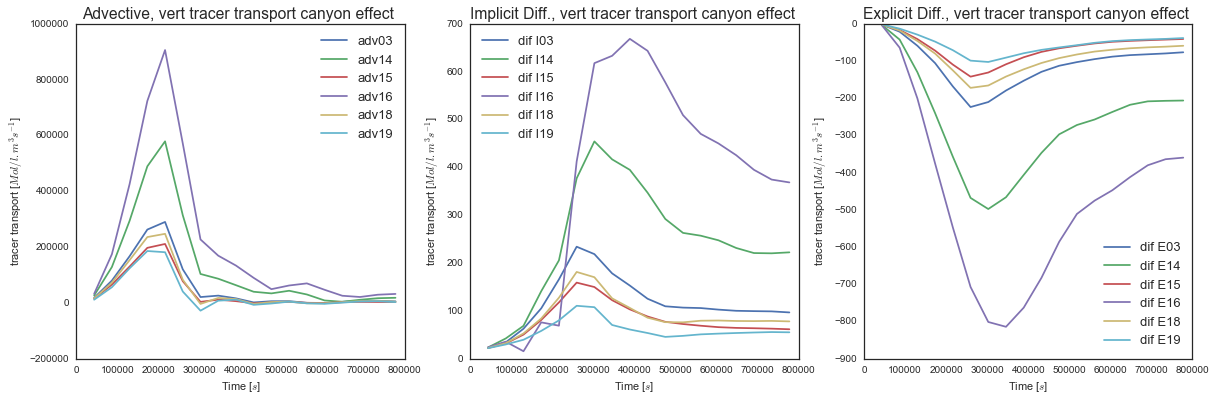

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

(advVR1_flux03).sum(dim='Y').plot(ax=ax[0], label = 'adv03')
(advVR1_flux14).sum(dim='Y').plot(ax=ax[0], label = 'adv14')
(advVR1_flux15).sum(dim='Y').plot(ax=ax[0], label = 'adv15')
(advVR1_flux16).sum(dim='Y').plot(ax=ax[0], label = 'adv16')
(advVR1_flux18).sum(dim='Y').plot(ax=ax[0], label = 'adv18')
(advVR1_flux19).sum(dim='Y').plot(ax=ax[0], label = 'adv19')



(difIVR1_flux03).sum(dim='Y').plot(ax=ax[1], label = 'dif I03')
(difIVR1_flux14).sum(dim='Y').plot(ax=ax[1], label = 'dif I14')
(difIVR1_flux15).sum(dim='Y').plot(ax=ax[1], label = 'dif I15')
(difIVR1_flux16).sum(dim='Y').plot(ax=ax[1], label = 'dif I16')
(difIVR1_flux18).sum(dim='Y').plot(ax=ax[1], label = 'dif I18')
(difIVR1_flux19).sum(dim='Y').plot(ax=ax[1], label = 'dif I19')


(difEVR1_flux03).sum(dim='Y').plot(ax=ax[2], label = 'dif E03')
(difEVR1_flux14).sum(dim='Y').plot(ax=ax[2], label = 'dif E14')
(difEVR1_flux15).sum(dim='Y').plot(ax=ax[2], label = 'dif E15')
(difEVR1_flux16).sum(dim='Y').plot(ax=ax[2], label = 'dif E16')
(difEVR1_flux18).sum(dim='Y').plot(ax=ax[2], label = 'dif E18')
(difEVR1_flux19).sum(dim='Y').plot(ax=ax[2], label = 'dif E19')


ax[0] = fig_looks(ax[0],title='Advective, vert tracer transport canyon effect ')
ax[1] = fig_looks(ax[1],title='Implicit Diff., vert tracer transport canyon effect ')
ax[1] = fig_looks(ax[2],title='Explicit Diff., vert tracer transport canyon effect ')

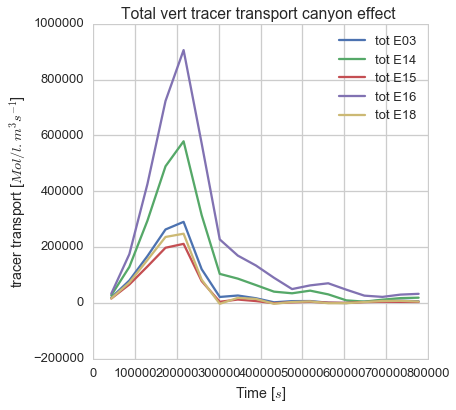

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

(difEVR1_flux03+difIVR1_flux03+advVR1_flux03).sum(dim='Y').plot(ax=ax, label = 'tot E03')
(difEVR1_flux14+difIVR1_flux14+advVR1_flux14).sum(dim='Y').plot(ax=ax, label = 'tot E14')
(difEVR1_flux15+difIVR1_flux15+advVR1_flux15).sum(dim='Y').plot(ax=ax, label = 'tot E15')
(difEVR1_flux16+difIVR1_flux16+advVR1_flux16).sum(dim='Y').plot(ax=ax, label = 'tot E16')
(difEVR1_flux18+difIVR1_flux18+advVR1_flux18).sum(dim='Y').plot(ax=ax, label = 'tot E18')


ax = fig_looks(ax,title='Total vert tracer transport canyon effect ')


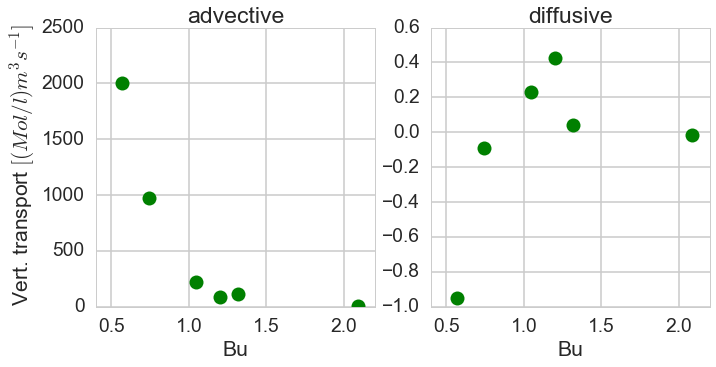

In [13]:
sns.set_context('poster',font_scale=1.2)


datasetsA = [advVR1_flux03,advVR1_flux14,advVR1_flux15,advVR1_flux16,advVR1_flux18,advVR1_flux19]
datasetsD = [difIVR1_flux03+difEVR1_flux03,difIVR1_flux14+difEVR1_flux14,
             difIVR1_flux15+difEVR1_flux15,difIVR1_flux16+difEVR1_flux16,
             difIVR1_flux18+difEVR1_flux18,difIVR1_flux19+difEVR1_flux19]

Hs = 152.5 # m
W = 8300.0 # m
N = np.array([5.5E-3,3.9E-3,6.3E-3,3.0E-3,5.5E-3,5.5E-3])
f = np.array([9.66E-5,9.66E-5,9.66E-5,9.66E-5,7.68E-5,4.84E-5])

Bu = (N*Hs)/(f*W)

fig,ax = plt.subplots(1,2,figsize=(11,5))

for data,dataV,ii in zip(datasetsA,datasetsD,range(len(Bu)+1)):
    
    ax[0].plot(Bu[ii],data[6:].mean(),'go',markersize=14)
    ax[1].plot(Bu[ii],dataV[6:].mean(),'go',markersize=14)
    
ax[0].set_ylabel(' Vert. transport $[(Mol/l)m^3s^{-1}]$')
ax[0].set_xlabel('Bu')
ax[0].set_title('advective')


ax[1].set_xlabel('Bu')
ax[1].set_title('diffusive')


plt.plot()

fig.savefig('adv_trac_vert_Nf.eps',format='eps',transparent=True,frameon=False,bbox_inches='tight')
